# Module

In [1]:
from dotenv import load_dotenv
import os

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import json
from IPython.display import Image, display

from langchain_core.messages import ToolMessage

# .env 파일 로드
load_dotenv()

True

### Memory checkpointer 생성

In [2]:
memory = MemorySaver()

### State 생성

In [36]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    cnt : int

### Graph 생성

In [37]:
graph_builder = StateGraph(State)

### Tool 및 LLM 생성

In [38]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

### Node 생성

In [39]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])], "cnt": state["cnt"] + 1}

tool_node = ToolNode(tools=tools)

### Node 및 Edge 연결

In [40]:
# Node 추가
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Edge 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

# conditional Edge 추가
graph_builder.add_conditional_edges("chatbot", tools_condition)

### 컴파일 - Checkpointer 활용

In [41]:
graph = graph_builder.compile(checkpointer=memory)

### 시각화

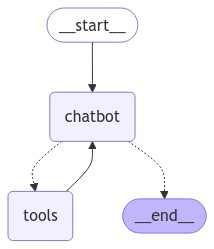

In [42]:
try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                output_file_path="./add_memory_to_chatbot.png"
            )
        )
    )
except Exception:
    pass

### 대화를 위한 config 설정

In [43]:
config = {"configurable": {"thread_id": "1"}}

### Run

In [45]:
user_input = "Hi there! My name is Rimo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)], "cnt":1}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Rimo.
================================== Ai Message ==================================

Hello Rimo! How can I assist you today?


In [12]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Rimo! How can I assist you further?


### Config가 바뀐다면?

In [50]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)], "cnt":1}, {"configurable":{"thread_id":"hi"}}, stream_mode="values"
)
for event in events:
    print(event["messages"])#[)-1].pretty_print()

[HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='17c92bc1-12b7-4051-848b-48c5f47dfd4b'), AIMessage(content="I'm sorry, but I don't have the ability to remember personal details or previous interactions. Can you please tell me your name again?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 83, 'total_tokens': 110, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90354628f2', 'finish_reason': 'stop', 'logprobs': None}, id='run-2e506d95-7188-4a82-b2a4-1db82e218764-0', usage_metadata={'input_tokens': 83, 'output_tokens': 27, 'total_tokens': 110, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='a0e3ec0

### 특정 config의 State 상태를 보려면?

In [56]:
snapshot = graph.get_state(config)

In [57]:
snapshot_value = snapshot.values

In [58]:
len(snapshot_value)

2

In [59]:
snapshot_value

{'messages': [HumanMessage(content='Hi there! My name is Rimo.', additional_kwargs={}, response_metadata={}, id='cd54af18-4746-42e0-af78-05df18811b5f'),
  AIMessage(content='Hello Rimo! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 88, 'total_tokens': 100, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-7fe40a17-2665-4335-83cc-c0ac535e13fb-0', usage_metadata={'input_tokens': 88, 'output_tokens': 12, 'total_tokens': 100, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
  HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='e4220930-f681-4532-8d64-b7b5fc2277c8'),
  AIMessage(content='Yes, your name 